<h1><center><b>NCAA March Madness 2022 Notebook</b></center></h1>

Special thanks to the following notebook:

https://www.kaggle.com/theoviel/ncaa-starter-the-simpler-the-better

Table of Contents:
    
    1.) Loading Necessities
        a.) Libraries
        b.) Dataset
    2.) Exploratory Data Analysis
        a.) Seeds
        b.) Season Results
        c.) Tourney Results
        d.) Team Statistics
        e.) Computer Ratings
    3.) Feature Engineering
        a.) Seeds
        b.) Team Statistics
        c.) Computer Ratings
        d.) Sabermetrics
    4.) Create Train and Test Sets
        a.) Add Symmetrical
        b.) Scoring Margins
        c.) Target Variable
        d.) Scale Variables
    5.) Modeling and Verifying Model
        b.) Logistic Regression
        c.) Random Forest
        d.) Multilevel Perceptron
        e.) XGBoost
        f.) Combined Model
    6.) Creating Submission
        a.) Predicting on Test Set
        b.) Preparing for Automatic Submission

## 1.) Loading Necessities

### 1A.) Load Libraries

In [91]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.metrics import classification_report
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

pd.set_option('display.max_columns', None)

from google.colab import drive
# Mount drive from Google
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [92]:
# Define paths
root_path = '/content/gdrive/MyDrive/Kaggle_competitions/March Machine Learning Mania 2022 - Men’s'
output_path = root_path + '/output'
submissions_path = root_path + '/submissions'
models_path = root_path + '/models'

# Define random state for reproducibility
random_state = 0

In [93]:
# Install kaggle
!pip -q install kaggle

# Upload the JSON file downloaded from kaggle (API token).
os.environ['KAGGLE_CONFIG_DIR'] = root_path + "/Kaggle"

kaggle_path = "'" + root_path +"/Kaggle'"
%cd $kaggle_path

# Download the dataset in zip format
!kaggle competitions download -c mens-march-mania-2022

# # List all the datasets available in Kaggle
# # !kaggle datasets list

# #Decompress the data
!unzip -o -q MGameCities.csv.zip
!unzip -o -q MMasseyOrdinals.csv.zip
!unzip -o -q MRegularSeasonCompactResults.csv.zip
!unzip -o -q MRegularSeasonDetailedResults.csv.zip

/content/gdrive/MyDrive/Kaggle_competitions/March Machine Learning Mania 2022 - Men’s/Kaggle
MSeasons.csv: Skipping, found more recently modified local copy (use --force to force download)
MMasseyOrdinals.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
MTeams.csv: Skipping, found more recently modified local copy (use --force to force download)
Cities.csv: Skipping, found more recently modified local copy (use --force to force download)
MSecondaryTourneyCompactResults.csv: Skipping, found more recently modified local copy (use --force to force download)
MTeamConferences.csv: Skipping, found more recently modified local copy (use --force to force download)
MNCAATourneyDetailedResults.csv: Skipping, found more recently modified local copy (use --force to force download)
MNCAATourneySlots.csv: Skipping, found more recently modified local copy (use --force to force download)
MRegularSeasonDetailedResults.csv.zip: Skipping, found more recently modi

### 1B.) Load Dataset

In [94]:
DATA_PATH = root_path + "/Kaggle/"
# DATA_PATH = '../input/ncaaw-march-mania-2022/'
# DATA_PATH_M = '../input/ncaam-march-mania-2022/'

for filename in os.listdir(DATA_PATH):
    print(filename)

kaggle.json
MSecondaryTourneyCompactResults.csv
MRegularSeasonDetailedResults.csv.zip
MNCAATourneyCompactResults.csv
MNCAATourneySlots.csv
Conferences.csv
MSampleSubmissionStage1.csv
MNCAATourneyDetailedResults.csv
MTeamConferences.csv
MTeamSpellings.csv
MNCAATourneySeedRoundSlots.csv
Cities.csv
MSeasons.csv
MNCAATourneySeeds.csv
MGameCities.csv.zip
MRegularSeasonCompactResults.csv.zip
MTeams.csv
MTeamCoaches.csv
MMasseyOrdinals.csv.zip
MConferenceTourneyGames.csv
MSecondaryTourneyTeams.csv
catboost_info
MGameCities.csv
MRegularSeasonCompactResults.csv
MMasseyOrdinals.csv
MRegularSeasonDetailedResults.csv


## 2.) Exploratory Data Analysis

### 2A.) Seeds

The Tournament Selection Committee seeds every team in the NCAA Tournament ranging from 1 (the best teams) to 16 (the worst ones). The tournament started with 8 teams in 1939 and has since expanded to 68 teams today (4 play-in games). On Selection Sunday (March 13, 2022), the committee releases the bracket with the seeds.

* First character : Region (W, X, Y, or Z)
* Next two digits : Seed within the region (01 to 16)
* Last character (optional): Distinguishes teams between play-ins ( a or b)

In [95]:
df_seeds = pd.read_csv(DATA_PATH + 'MNCAATourneySeeds.csv')
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


### 2B.) Season Results

In [96]:
df_season_results = pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv")
# df_season_results = pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv")
df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [97]:
df_season_results['ScoreMargin'] = df_season_results['WScore'] - df_season_results['LScore']

In [98]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreMargin
0,2003,10,1104,68,1328,62,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,6


In [99]:
sabermetrics = pd.DataFrame()

sabermetrics['Season'] = df_season_results['Season']
sabermetrics['WTeamID'] = df_season_results['WTeamID']
sabermetrics['LTeamID'] = df_season_results['LTeamID']

# Number of Possessions
sabermetrics['WPossessions'] = (df_season_results['WFGA'] - df_season_results['WOR']) + df_season_results['WTO'] + .44 * df_season_results['WFTA']
sabermetrics['LPossessions'] = (df_season_results['LFGA'] - df_season_results['LOR']) + df_season_results['LTO'] + .44 * df_season_results['LFTA']

df_season_results['WPossessions'] = sabermetrics['WPossessions']
df_season_results['LPossessions'] = sabermetrics['LPossessions']

# Points Per Possession
sabermetrics['WPtsPerPoss'] = df_season_results['WScore'] / df_season_results['WPossessions']
sabermetrics['LPtsPerPoss'] = df_season_results['LScore'] / df_season_results['LPossessions']

# Effective Field Goal Percentage
sabermetrics['WEffectiveFGPct'] = ((df_season_results['WScore'] - df_season_results['WFTM']) / 2) / df_season_results['WFGA']
sabermetrics['LEffectiveFGPct'] = ((df_season_results['LScore'] - df_season_results['LFTM']) / 2) / df_season_results['LFGA']

# Percentage of Field Goals Assisted
sabermetrics['WAssistRate'] = df_season_results['WAst'] / df_season_results['WFGM']
sabermetrics['LAssistRate'] = df_season_results['LAst'] / df_season_results['LFGM']

# Offensive Rebound Percentage
sabermetrics['WOReboundPct'] = df_season_results['WOR'] / (df_season_results['WFGA'] - df_season_results['WFGM'])
sabermetrics['LOReboundPct'] = df_season_results['LOR'] / (df_season_results['LFGA'] - df_season_results['LFGM'])

# Defensive Rebound Percentage
sabermetrics['WDReboundPct'] = df_season_results['WDR'] / (df_season_results['LFGA'] - df_season_results['LFGM'])
sabermetrics['LDReboundPct'] = df_season_results['LDR'] / (df_season_results['WFGA'] - df_season_results['WFGM'])

# Assist to Turnover Ratio
sabermetrics['WATORatio'] = df_season_results['WAst'] / df_season_results['WTO']
sabermetrics['LATORatio'] = df_season_results['LAst'] / df_season_results['LTO']

# Turnover Rate
sabermetrics['WTORate'] = df_season_results['WTO'] / df_season_results['WPossessions']
sabermetrics['LTORate'] = df_season_results['LTO'] /  df_season_results['LPossessions']

# Percentage of Shots Beyond the Arc
sabermetrics['WBArcPct'] = df_season_results['WFGA3'] / df_season_results['WFGA']
sabermetrics['LBArcPct'] = df_season_results['LFGA3'] /  df_season_results['LFGA']

# Free Throw Rate
sabermetrics['WFTRate'] = df_season_results['WFTA'] / df_season_results['WFGA']
sabermetrics['LFTRate'] = df_season_results['LFTA'] /  df_season_results['LFGA']


In [100]:
winning_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'W']]
losing_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'L']]
winning_columns.loc[:, 'Season'] = sabermetrics['Season']
losing_columns.loc[:, 'Season'] = sabermetrics['Season']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [101]:
winning_columns.groupby(['Season', 'WTeamID']).mean()


WPossessions  WPtsPerPoss  WEffectiveFGPct  WAssistRate  \
Season WTeamID                                                            
2003   1102        56.380000     1.224741         0.692162     0.746082   
       1103        72.144615     1.218303         0.592604     0.593458   
       1104        67.795294     1.103197         0.506056     0.551302   
       1105        76.600000     1.036343         0.488400     0.618892   
       1106        67.907692     1.005881         0.517668     0.530133   
...                      ...          ...              ...          ...   
2022   1468        63.053333     1.183584         0.592994     0.601700   
       1469        72.794286     1.096535         0.533165     0.636728   
       1470        63.610000     1.111743         0.536540     0.551508   
       1471        71.210000     1.115187         0.577662     0.540697   
       1472        66.320000     1.272991         0.620242     0.519341   

                WOReboundPct  WDReboundPct  WATORatio   WTORate  WBArcPct  \
Season WTeamID                                                              
2003   1102         0.216934      0.693586   1.875770  0.194352  0.536901   
       1103         0.365924      0.665062   1.534233  0.175252  0.263396   
       1104         0.413266      0.749571   1.177279  0.191923  0.357570   
       1105         0.404129      0.754657   0.942261  0.235009  0.366514   
       1106         0.431874      0.805576   0.756597  0.261162  0.301302   
...                      ...           ...        ...       ...       ...   
2022   1468         0.200470      0.718124   2.592229  0.126370  0.396946   
       1469         0.272403      0.728655   1.525541  0.162211  0.359522   
       1470         0.260685      0.691702   1.715395  0.144818  0.337367   
       1471         0.166350      0.721321   1.104673  0.186423  0.450288   
       1472         0.187473      0.717819   2.698333  0.103040  0.541325   

                 WFTRate  
Season WTeamID            
2003   1102     0.541714  
       1103     0.554488  
       1104     0.392488  
       1105     0.425332  
       1106     0.395797  
...                  ...  
2022   1468     0.240419  
       1469     0.353851  
       1470     0.352914  
       1471     0.487936  
       1472     0.222046  

[6883 rows x 10 columns]

In [102]:
losing_columns.groupby(['Season', 'LTeamID']).mean()

LPossessions  LPtsPerPoss  LEffectiveFGPct  LAssistRate  \
Season LTeamID                                                            
2003   1102        53.200000     0.917240         0.503591     0.604671   
       1103        68.160000     1.028430         0.484527     0.529464   
       1104        63.483636     0.955762         0.429002     0.431948   
       1105        76.301053     0.903714         0.446777     0.583636   
       1106        66.736000     0.891659         0.450522     0.467619   
...                      ...          ...              ...          ...   
2022   1468        65.178182     0.922326         0.467822     0.463976   
       1469        75.080000     0.851263         0.431333     0.594451   
       1470        66.575385     0.884939         0.416007     0.379926   
       1471        67.583333     0.876517         0.470668     0.519170   
       1472        68.285714     1.005266         0.491830     0.431302   

                LOReboundPct  LDReboundPct  LATORatio   LTORate  LBArcPct  \
Season LTeamID                                                              
2003   1102         0.186039      0.756516   0.999534  0.216997  0.504743   
       1103         0.313076      0.703148   1.129718  0.187378  0.312603   
       1104         0.396990      0.738274   0.706652  0.215706  0.329571   
       1105         0.346275      0.718607   0.832372  0.246354  0.328804   
       1106         0.346249      0.717663   0.694235  0.246039  0.340581   
...                      ...           ...        ...       ...       ...   
2022   1468         0.191651      0.684441   1.132917  0.170184  0.400730   
       1469         0.238385      0.748675   0.924233  0.226333  0.378163   
       1470         0.207885      0.679568   0.798383  0.160190  0.287187   
       1471         0.158521      0.670214   0.989052  0.194125  0.447261   
       1472         0.160303      0.724849   1.429921  0.121470  0.486120   

                 LFTRate  
Season LTeamID            
2003   1102     0.375427  
       1103     0.382163  
       1104     0.341227  
       1105     0.335248  
       1106     0.231093  
...                  ...  
2022   1468     0.228603  
       1469     0.399463  
       1470     0.296166  
       1471     0.282874  
       1472     0.213144  

[6889 rows x 10 columns]

In [103]:
sabermetrics_season_w = winning_columns.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
sabermetrics_season_l = losing_columns.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

### Compute Wins, Losses, ScoreMarginWin, ScoreMarginLoss

In [104]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"}).fillna(0)

In [105]:
num_win.isna().sum()

Season     0
TeamID     0
NumWins    0
dtype: int64

In [106]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"}).fillna(0)

In [107]:
win_score_margin = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
win_score_margin = win_score_margin[['Season', 'WTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgWinningScoreMargin", "WTeamID": "TeamID"}).fillna(0)

In [108]:
lose_score_margin = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
lose_score_margin = lose_score_margin[['Season', 'LTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgLosingScoreMargin", "LTeamID": "TeamID"}).fillna(0)

## Merge the results together

In [109]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [110]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [111]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(win_score_margin, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(lose_score_margin, on=['Season', 'TeamID'], how='left')

In [112]:
df_features_season

,Season,TeamID,NumWins,NumLosses,AvgWinningScoreMargin,AvgLosingScoreMargin
0,2003,1102,12.0,16.0,15.583333,11.250000
1,2003,1103,13.0,14.0,9.384615,7.500000
2,2003,1104,17.0,11.0,13.176471,9.454545
3,2003,1105,7.0,19.0,13.000000,11.473684
4,2003,1106,13.0,15.0,10.384615,9.266667
...,...,...,...,...,...,...
6887,2022,1468,9.0,11.0,10.666667,16.545455
6888,2022,1469,7.0,12.0,11.428571,19.333333
6889,2022,1470,8.0,13.0,11.125000,11.769231
6890,2022,1471,8.0,12.0,10.125000,13.416667


In [113]:
df_features_season['NumWins'] = df_features_season['NumWins'].fillna(0)
df_features_season['NumLosses'] = df_features_season['NumLosses'].fillna(0)
df_features_season['AvgWinningScoreMargin'] = df_features_season['AvgWinningScoreMargin'].fillna(0)
df_features_season['AvgLosingScoreMargin'] = df_features_season['AvgLosingScoreMargin'].fillna(0)

In [114]:
df_features_season['WinPercentage'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['AvgScoringMargin'] = (
    (df_features_season['NumWins'] * df_features_season['AvgWinningScoreMargin'] - 
    df_features_season['NumLosses'] * df_features_season['AvgLosingScoreMargin'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [115]:
df_features_season.drop(['AvgWinningScoreMargin', 'AvgLosingScoreMargin'], axis=1, inplace=True)

In [116]:
df_features_season.isna().sum()

Season              0
TeamID              0
NumWins             0
NumLosses           0
WinPercentage       0
AvgScoringMargin    0
dtype: int64

In [117]:
df_features_season

,Season,TeamID,NumWins,NumLosses,WinPercentage,AvgScoringMargin
0,2003,1102,12.0,16.0,0.428571,0.250000
1,2003,1103,13.0,14.0,0.481481,0.629630
2,2003,1104,17.0,11.0,0.607143,4.285714
3,2003,1105,7.0,19.0,0.269231,-4.884615
4,2003,1106,13.0,15.0,0.464286,-0.142857
...,...,...,...,...,...,...
6887,2022,1468,9.0,11.0,0.450000,-4.300000
6888,2022,1469,7.0,12.0,0.368421,-8.000000
6889,2022,1470,8.0,13.0,0.380952,-3.047619
6890,2022,1471,8.0,12.0,0.400000,-4.000000


### 2C.) Tourney Results

In [118]:
df_tourney_results = pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv")
# df_tourney_results = pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv")
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [119]:
df_tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1985,136,1116,63,1234,54
1,1985,136,1120,59,1345,58
2,1985,136,1207,68,1250,43
3,1985,136,1229,58,1425,55
4,1985,136,1242,49,1325,38


### 2D.) Computer Ratings

In [120]:
df_massey = pd.read_csv(DATA_PATH + "MMasseyOrdinals.csv")
df_massey = df_massey[df_massey['RankingDayNum'] == 133].drop('RankingDayNum', axis=1).reset_index(drop=True) # use first day of the tournament

In [121]:
df_massey

,Season,SystemName,TeamID,OrdinalRank
0,2003,AP,1112,2
1,2003,AP,1163,23
2,2003,AP,1166,15
3,2003,AP,1173,16
4,2003,AP,1181,7
...,...,...,...,...
309504,2021,WOB,1467,233
309505,2021,WOB,1468,176
309506,2021,WOB,1469,290
309507,2021,WOB,1470,256


In [122]:
systems = []
for year in range(2003, 2019):
    r = df_massey[df_massey['Season'] == year]
    systems.append(r['SystemName'].unique())
    
all_systems = list(set(list(np.concatenate(systems))))

In [123]:
common_systems = []  
for system in all_systems:
    common = True
    for system_years in systems:
        if system not in system_years:
            common = False
    if common:
        common_systems.append(system)
        
common_systems

['RTH', 'USA', 'AP', 'WOL', 'COL', 'DOL', 'MOR', 'POM', 'RPI', 'WLK', 'SAG']

## 3.) Feature Engineering

In [124]:
df = df_tourney_results.copy()
df = df[df['Season'] >= 2003].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


### 3A.) Seeds

In [125]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [126]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [127]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2003,134,1421,92,1411,84,X16b,X16a
1,2003,136,1112,80,1436,51,Z01,Z16
2,2003,136,1113,84,1272,71,Z10,Z07
3,2003,136,1141,79,1166,73,Z11,Z06
4,2003,136,1143,76,1301,74,W08,W09
...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,X01,X06
1177,2021,148,1417,51,1276,49,W11b,W01
1178,2021,152,1124,78,1222,59,Z01,Y02
1179,2021,152,1211,93,1417,90,X01,W11b


In [128]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [129]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [130]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2003,134,1421,92,1411,84,16,16
1,2003,136,1112,80,1436,51,1,16
2,2003,136,1113,84,1272,71,10,7
3,2003,136,1141,79,1166,73,11,6
4,2003,136,1143,76,1301,74,8,9


### 3B.) Season Stats
- `WinRatioW` is the winning percentage of the winning team during the season
- `WinRatioL` is the winning percentage of the losing team during the season

In [131]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginW',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginW',
    'WinPercentage': 'WinPercentageW',
    'AvgScoringMargin': 'AvgScoringMarginW',
}).drop(columns='TeamID', axis=1)

df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginL',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginL',
    'WinPercentage': 'WinPercentageL',
    'AvgScoringMargin': 'AvgScoringMarginL',
}).drop(columns='TeamID', axis=1)

### 3C.) Computer Ratings

In [132]:
avg_ranking = df_massey.groupby(['Season', 'TeamID']).mean().reset_index()

df = pd.merge(
     df,
     avg_ranking,
     how='left',
     left_on=['Season', 'WTeamID'],
     right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankW'})

df = pd.merge(
    df, 
    avg_ranking, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankL'})

In [133]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,NumWinsW,NumLossesW,WinPercentageW,AvgScoringMarginW,NumWinsL,NumLossesL,WinPercentageL,AvgScoringMarginL,ComputerRankW,ComputerRankL
0,2003,134,1421,92,1411,84,16,16,13.0,16.0,0.448276,-7.241379,18.0,12.0,0.600000,1.966667,240.343750,239.281250
1,2003,136,1112,80,1436,51,1,16,25.0,3.0,0.892857,14.964286,19.0,10.0,0.655172,4.655172,2.676471,153.125000
2,2003,136,1113,84,1272,71,10,7,18.0,11.0,0.620690,6.793103,23.0,6.0,0.793103,8.689655,36.000000,21.705882
3,2003,136,1141,79,1166,73,11,6,23.0,6.0,0.793103,6.103448,29.0,4.0,0.878788,14.909091,45.687500,20.735294
4,2003,136,1143,76,1301,74,8,9,21.0,8.0,0.724138,4.724138,18.0,12.0,0.600000,4.400000,36.406250,50.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,1,6,26.0,0.0,1.000000,23.000000,22.0,7.0,0.758621,9.655172,1.037037,16.796296
1177,2021,148,1417,51,1276,49,11,1,17.0,9.0,0.653846,4.346154,20.0,4.0,0.833333,10.875000,45.596154,4.833333
1178,2021,152,1124,78,1222,59,1,2,22.0,2.0,0.916667,17.958333,23.0,3.0,0.884615,18.000000,3.074074,5.185185
1179,2021,152,1211,93,1417,90,1,11,26.0,0.0,1.000000,23.000000,17.0,9.0,0.653846,4.346154,1.037037,45.596154


### 3D.) Sabermetrics

In [134]:
sabermetrics = pd.DataFrame()

sabermetrics['Season'] = df_season_results['Season']
sabermetrics['WTeamID'] = df_season_results['WTeamID']
sabermetrics['LTeamID'] = df_season_results['LTeamID']

# Number of Possessions
sabermetrics['WPossessions'] = (df_season_results['WFGA'] - df_season_results['WOR']) + df_season_results['WTO'] + .44 * df_season_results['WFTA']
sabermetrics['LPossessions'] = (df_season_results['LFGA'] - df_season_results['LOR']) + df_season_results['LTO'] + .44 * df_season_results['LFTA']

df_season_results['WPossessions'] = sabermetrics['WPossessions']
df_season_results['LPossessions'] = sabermetrics['LPossessions']

# Points Per Possession
sabermetrics['WPtsPerPoss'] = df_season_results['WScore'] / df_season_results['WPossessions']
sabermetrics['LPtsPerPoss'] = df_season_results['LScore'] / df_season_results['LPossessions']

# Effective Field Goal Percentage
sabermetrics['WEffectiveFGPct'] = ((df_season_results['WScore'] - df_season_results['WFTM']) / 2) / df_season_results['WFGA']
sabermetrics['LEffectiveFGPct'] = ((df_season_results['LScore'] - df_season_results['LFTM']) / 2) / df_season_results['LFGA']

# Percentage of Field Goals Assisted
sabermetrics['WAssistRate'] = df_season_results['WAst'] / df_season_results['WFGM']
sabermetrics['LAssistRate'] = df_season_results['LAst'] / df_season_results['LFGM']

# Offensive Rebound Percentage
sabermetrics['WOReboundPct'] = df_season_results['WOR'] / (df_season_results['WFGA'] - df_season_results['WFGM'])
sabermetrics['LOReboundPct'] = df_season_results['LOR'] / (df_season_results['LFGA'] - df_season_results['LFGM'])

# Defensive Rebound Percentage
sabermetrics['WDReboundPct'] = df_season_results['WDR'] / (df_season_results['LFGA'] - df_season_results['LFGM'])
sabermetrics['LDReboundPct'] = df_season_results['LDR'] / (df_season_results['WFGA'] - df_season_results['WFGM'])

# Assist to Turnover Ratio
sabermetrics['WATORatio'] = df_season_results['WAst'] / df_season_results['WTO']
sabermetrics['LATORatio'] = df_season_results['LAst'] / df_season_results['LTO']

# Turnover Rate
sabermetrics['WTORate'] = df_season_results['WTO'] / df_season_results['WPossessions']
sabermetrics['LTORate'] = df_season_results['LTO'] /  df_season_results['LPossessions']

# Percentage of Shots Beyond the Arc
sabermetrics['WBArcPct'] = df_season_results['WFGA3'] / df_season_results['WFGA']
sabermetrics['LBArcPct'] = df_season_results['LFGA3'] /  df_season_results['LFGA']

# Free Throw Rate
sabermetrics['WFTRate'] = df_season_results['WFTA'] / df_season_results['WFGA']
sabermetrics['LFTRate'] = df_season_results['LFTA'] /  df_season_results['LFGA']


In [135]:
sabermetrics

,Season,WTeamID,LTeamID,WPossessions,LPossessions,WPtsPerPoss,LPtsPerPoss,WEffectiveFGPct,LEffectiveFGPct,WAssistRate,LAssistRate,WOReboundPct,LOReboundPct,WDReboundPct,LDReboundPct,WATORatio,LATORatio,WTORate,LTORate,WBArcPct,LBArcPct,WFTRate,LFTRate
0,2003,1104,1328,74.92,70.68,0.907635,0.877193,0.491379,0.433962,0.481481,0.363636,0.451613,0.322581,0.774194,0.709677,0.565217,0.444444,0.306994,0.254669,0.241379,0.188679,0.310345,0.415094
1,2003,1272,1393,68.36,67.80,1.023991,0.929204,0.483871,0.402985,0.615385,0.291667,0.416667,0.465116,0.651163,0.694444,1.230769,0.583333,0.190170,0.176991,0.322581,0.358209,0.306452,0.298507
2,2003,1266,1437,63.76,64.12,1.144918,0.951341,0.482759,0.321918,0.625000,0.409091,0.500000,0.607843,0.509804,0.647059,1.500000,0.750000,0.156838,0.187149,0.310345,0.356164,0.500000,0.315068
3,2003,1296,1457,57.64,57.60,0.971548,0.868056,0.513158,0.428571,0.611111,0.500000,0.300000,0.548387,0.612903,1.000000,0.916667,0.473684,0.208189,0.329861,0.236842,0.448980,0.815789,0.306122
4,2003,1400,1208,63.72,62.88,1.208412,1.129135,0.540984,0.435484,0.400000,0.500000,0.548387,0.552632,0.578947,0.483871,0.857143,1.200000,0.219711,0.159033,0.229508,0.258065,0.213115,0.435484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100418,2022,1400,1242,69.12,68.12,1.142940,1.115678,0.440299,0.635417,0.285714,0.357143,0.358974,0.250000,0.900000,0.615385,1.333333,0.666667,0.086806,0.220200,0.298507,0.270833,0.343284,0.479167
100419,2022,1411,1126,78.32,73.56,0.842697,0.856444,0.423729,0.489796,0.375000,0.500000,0.342857,0.172414,0.931034,0.657143,0.473684,0.526316,0.242594,0.258293,0.338983,0.428571,0.474576,0.489796
100420,2022,1422,1441,65.72,63.84,1.034693,0.767544,0.526786,0.386792,0.478261,0.277778,0.333333,0.285714,0.628571,0.545455,0.733333,0.312500,0.228241,0.250627,0.571429,0.452830,0.232143,0.207547
100421,2022,1438,1181,63.96,64.68,1.078799,1.051330,0.492308,0.480769,0.516129,0.636364,0.294118,0.366667,0.666667,0.735294,3.200000,1.000000,0.078174,0.216450,0.184615,0.326923,0.138462,0.423077


In [136]:
winning_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'W']]
losing_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'L']]
winning_columns.loc[:, 'Season'] = sabermetrics['Season']
losing_columns.loc[:, 'Season'] = sabermetrics['Season']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [137]:
winning_sabermetrics = winning_columns.groupby(['Season', 'WTeamID']).mean()
losing_sabermetrics = losing_columns.groupby(['Season', 'LTeamID']).mean()

In [138]:
losing_sabermetrics

LPossessions  LPtsPerPoss  LEffectiveFGPct  LAssistRate  \
Season LTeamID                                                            
2003   1102        53.200000     0.917240         0.503591     0.604671   
       1103        68.160000     1.028430         0.484527     0.529464   
       1104        63.483636     0.955762         0.429002     0.431948   
       1105        76.301053     0.903714         0.446777     0.583636   
       1106        66.736000     0.891659         0.450522     0.467619   
...                      ...          ...              ...          ...   
2022   1468        65.178182     0.922326         0.467822     0.463976   
       1469        75.080000     0.851263         0.431333     0.594451   
       1470        66.575385     0.884939         0.416007     0.379926   
       1471        67.583333     0.876517         0.470668     0.519170   
       1472        68.285714     1.005266         0.491830     0.431302   

                LOReboundPct  LDReboundPct  LATORatio   LTORate  LBArcPct  \
Season LTeamID                                                              
2003   1102         0.186039      0.756516   0.999534  0.216997  0.504743   
       1103         0.313076      0.703148   1.129718  0.187378  0.312603   
       1104         0.396990      0.738274   0.706652  0.215706  0.329571   
       1105         0.346275      0.718607   0.832372  0.246354  0.328804   
       1106         0.346249      0.717663   0.694235  0.246039  0.340581   
...                      ...           ...        ...       ...       ...   
2022   1468         0.191651      0.684441   1.132917  0.170184  0.400730   
       1469         0.238385      0.748675   0.924233  0.226333  0.378163   
       1470         0.207885      0.679568   0.798383  0.160190  0.287187   
       1471         0.158521      0.670214   0.989052  0.194125  0.447261   
       1472         0.160303      0.724849   1.429921  0.121470  0.486120   

                 LFTRate  
Season LTeamID            
2003   1102     0.375427  
       1103     0.382163  
       1104     0.341227  
       1105     0.335248  
       1106     0.231093  
...                  ...  
2022   1468     0.228603  
       1469     0.399463  
       1470     0.296166  
       1471     0.282874  
       1472     0.213144  

[6889 rows x 10 columns]

In [139]:
winning_sabermetrics = winning_sabermetrics \
                        .reset_index() \
                        .merge(df_features_season[['Season', 'TeamID', 'NumWins']], left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left') \
                        .set_index(['Season', 'WTeamID']) \
                        .drop(['TeamID'], axis=1)

losing_sabermetrics = losing_sabermetrics \
                        .reset_index() \
                        .merge(df_features_season[['Season', 'TeamID', 'NumLosses']], left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left') \
                        .set_index(['Season', 'LTeamID']) \
                        .drop(['TeamID'], axis=1)

In [140]:
weighted_sabermetrics_wins = winning_sabermetrics[[col for col in winning_sabermetrics.columns if col[0] == 'W']].multiply(winning_sabermetrics['NumWins'], axis=0)
weighted_sabermetrics_losses = losing_sabermetrics[[col for col in losing_sabermetrics.columns if col[0] == 'L']].multiply(losing_sabermetrics['NumLosses'], axis=0)

weighted_sabermetrics = pd.DataFrame()
weighted_sabermetrics['Possessions'] = (weighted_sabermetrics_wins['WPossessions'] + weighted_sabermetrics_losses['LPossessions']) /  \
                                       (winning_sabermetrics['NumWins'] + losing_sabermetrics['NumLosses'])

combined_df = winning_sabermetrics.reset_index().merge(losing_sabermetrics.reset_index(), left_on=['WTeamID', 'Season'], right_on=['LTeamID', 'Season'], how='outer')

def weighted_metric(metric, df=combined_df.set_index(['Season', 'WTeamID'], inplace=True)):
    """Computes the weighted stat from winning and losing metric"""
        
    weighted_df = ((combined_df[f'W{metric}'].mul(combined_df['NumWins']) + combined_df[f'L{metric}'].mul(combined_df['NumLosses'])) \
    / (combined_df['NumWins'] + combined_df['NumLosses']))
    return weighted_df

In [141]:
combined_df.reset_index(inplace=True)
combined_df['WTeamID'].fillna(combined_df['LTeamID'], inplace=True)
combined_df['LTeamID'].fillna(combined_df['WTeamID'], inplace=True)
combined_df.set_index(['Season', 'WTeamID'], inplace=True)
combined_df.fillna(0, inplace=True)

In [142]:
combined_df

WPossessions  WPtsPerPoss  WEffectiveFGPct  WAssistRate  \
Season WTeamID                                                            
2003   1102.0      56.380000     1.224741         0.692162     0.746082   
       1103.0      72.144615     1.218303         0.592604     0.593458   
       1104.0      67.795294     1.103197         0.506056     0.551302   
       1105.0      76.600000     1.036343         0.488400     0.618892   
       1106.0      67.907692     1.005881         0.517668     0.530133   
...                      ...          ...              ...          ...   
2015   1363.0       0.000000     0.000000         0.000000     0.000000   
2021   1152.0       0.000000     0.000000         0.000000     0.000000   
2022   1175.0       0.000000     0.000000         0.000000     0.000000   
       1237.0       0.000000     0.000000         0.000000     0.000000   
       1249.0       0.000000     0.000000         0.000000     0.000000   

                WOReboundPct  WDReboundPct  WATORatio   WTORate  WBArcPct  \
Season WTeamID                                                              
2003   1102.0       0.216934      0.693586   1.875770  0.194352  0.536901   
       1103.0       0.365924      0.665062   1.534233  0.175252  0.263396   
       1104.0       0.413266      0.749571   1.177279  0.191923  0.357570   
       1105.0       0.404129      0.754657   0.942261  0.235009  0.366514   
       1106.0       0.431874      0.805576   0.756597  0.261162  0.301302   
...                      ...           ...        ...       ...       ...   
2015   1363.0       0.000000      0.000000   0.000000  0.000000  0.000000   
2021   1152.0       0.000000      0.000000   0.000000  0.000000  0.000000   
2022   1175.0       0.000000      0.000000   0.000000  0.000000  0.000000   
       1237.0       0.000000      0.000000   0.000000  0.000000  0.000000   
       1249.0       0.000000      0.000000   0.000000  0.000000  0.000000   

                 WFTRate  NumWins  LTeamID  LPossessions  LPtsPerPoss  \
Season WTeamID                                                          
2003   1102.0   0.541714     12.0   1102.0     53.200000     0.917240   
       1103.0   0.554488     13.0   1103.0     68.160000     1.028430   
       1104.0   0.392488     17.0   1104.0     63.483636     0.955762   
       1105.0   0.425332      7.0   1105.0     76.301053     0.903714   
       1106.0   0.395797     13.0   1106.0     66.736000     0.891659   
...                  ...      ...      ...           ...          ...   
2015   1363.0   0.000000      0.0   1363.0     63.524286     0.828766   
2021   1152.0   0.000000      0.0   1152.0     71.271111     0.777963   
2022   1175.0   0.000000      0.0   1175.0     69.610000     0.823098   
       1237.0   0.000000      0.0   1237.0     62.587368     0.801314   
       1249.0   0.000000      0.0   1249.0     67.886000     0.921716   

                LEffectiveFGPct  LAssistRate  LOReboundPct  LDReboundPct  \
Season WTeamID                                                             
2003   1102.0          0.503591     0.604671      0.186039      0.756516   
       1103.0          0.484527     0.529464      0.313076      0.703148   
       1104.0          0.429002     0.431948      0.396990      0.738274   
       1105.0          0.446777     0.583636      0.346275      0.718607   
       1106.0          0.450522     0.467619      0.346249      0.717663   
...                         ...          ...           ...           ...   
2015   1363.0          0.414186     0.532765      0.255475      0.791549   
2021   1152.0          0.411805     0.495579      0.135667      0.648177   
2022   1175.0          0.425513     0.405529      0.241031      0.620454   
       1237.0          0.419662     0.534036      0.248416      0.684896   
       1249.0          0.449242     0.472709      0.282058      0.706590   

                LATORatio   LTORate  LBArcPct   LFTRate  NumLosses  
Season WTeamID                

In [143]:
metrics_list = ['Possessions', 'PtsPerPoss', 'EffectiveFGPct', 'AssistRate', 'OReboundPct', 'DReboundPct', 'ATORatio', 'TORate', 'BArcPct', 'FTRate']
season_sabermetrics = pd.concat([weighted_metric(metric) for metric in metrics_list], axis=1)
season_sabermetrics.columns=metrics_list

In [144]:
season_sabermetrics.sort_index(inplace=True)

In [145]:
season_sabermetrics.index.columns = ['Season', 'TeamID']

In [146]:
season_sabermetrics.reset_index(inplace=True)

In [147]:
season_sabermetrics

,Season,WTeamID,Possessions,PtsPerPoss,EffectiveFGPct,AssistRate,OReboundPct,DReboundPct,ATORatio,TORate,BArcPct,FTRate
0,2003,1102.0,54.562857,1.049026,0.584407,0.665276,0.199280,0.729546,1.375064,0.207292,0.518525,0.446693
1,2003,1103.0,70.078519,1.119851,0.536564,0.560276,0.338522,0.684811,1.324485,0.181540,0.288910,0.465135
2,2003,1104.0,66.101429,1.045276,0.475785,0.504413,0.406872,0.745133,0.992390,0.201266,0.346570,0.372350
3,2003,1105.0,76.381538,0.939422,0.457983,0.593128,0.361851,0.728313,0.861957,0.243300,0.338957,0.359501
4,2003,1106.0,67.280000,0.944691,0.481697,0.496643,0.386003,0.758479,0.723189,0.253060,0.322344,0.307563
...,...,...,...,...,...,...,...,...,...,...,...,...
6887,2022,1468.0,64.222000,1.039892,0.524149,0.525952,0.195620,0.699598,1.789608,0.150467,0.399027,0.233920
6888,2022,1469.0,74.237895,0.941626,0.468850,0.610027,0.250918,0.741299,1.145767,0.202709,0.371295,0.382658
6889,2022,1470.0,65.445714,0.971341,0.461925,0.445291,0.227999,0.684191,1.147721,0.154334,0.306303,0.317784
6890,2022,1471.0,69.034000,0.971985,0.513466,0.527781,0.161652,0.690656,1.035300,0.191044,0.448472,0.364899


In [148]:
df = df.merge(season_sabermetrics, left_on=['Season', 'WTeamID'], right_on=['Season', 'WTeamID'], how='left', suffixes=[None, 'W'])
df = df.merge(season_sabermetrics, left_on=['Season', 'LTeamID'], right_on=['Season', 'WTeamID'], how='left', suffixes=[None, 'L'])

In [149]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,NumWinsW,NumLossesW,WinPercentageW,AvgScoringMarginW,NumWinsL,NumLossesL,WinPercentageL,AvgScoringMarginL,ComputerRankW,ComputerRankL,Possessions,PtsPerPoss,EffectiveFGPct,AssistRate,OReboundPct,DReboundPct,ATORatio,TORate,BArcPct,FTRate,WTeamIDL,PossessionsL,PtsPerPossL,EffectiveFGPctL,AssistRateL,OReboundPctL,DReboundPctL,ATORatioL,TORateL,BArcPctL,FTRateL
0,2003,134,1421,92,1411,84,16,16,13.0,16.0,0.448276,-7.241379,18.0,12.0,0.600000,1.966667,240.343750,239.281250,69.933793,1.022026,0.489800,0.524912,0.377268,0.697730,0.916938,0.230355,0.318374,0.377214,1411.0,69.682667,1.043758,0.503036,0.574708,0.428733,0.724640,0.983780,0.218210,0.334566,0.529491
1,2003,136,1112,80,1436,51,1,16,25.0,3.0,0.892857,14.964286,19.0,10.0,0.655172,4.655172,2.676471,153.125000,76.321429,1.119123,0.517632,0.579706,0.430264,0.724040,1.293499,0.192304,0.304801,0.387965,1436.0,65.568276,1.037144,0.494732,0.568251,0.428411,0.802653,1.077472,0.215063,0.278226,0.356274
2,2003,136,1113,84,1272,71,10,7,18.0,11.0,0.620690,6.793103,23.0,6.0,0.793103,8.689655,36.000000,21.705882,68.737931,1.107215,0.517334,0.572377,0.470811,0.764390,1.203251,0.203347,0.221225,0.468561,1272.0,69.798621,1.067067,0.498337,0.628944,0.412877,0.765180,1.293030,0.196348,0.334928,0.396624
3,2003,136,1141,79,1166,73,11,6,23.0,6.0,0.793103,6.103448,29.0,4.0,0.878788,14.909091,45.687500,20.735294,71.420690,1.109304,0.572835,0.584497,0.406714,0.752266,0.876120,0.255957,0.345636,0.481836,1166.0,68.752727,1.149794,0.567455,0.579207,0.381168,0.744973,1.331533,0.194492,0.357186,0.354147
4,2003,136,1143,76,1301,74,8,9,21.0,8.0,0.724138,4.724138,18.0,12.0,0.600000,4.400000,36.406250,50.312500,70.242759,1.062731,0.524098,0.581999,0.353136,0.736381,1.223081,0.200291,0.289856,0.348311,1301.0,66.805333,1.083542,0.534189,0.598666,0.332344,0.755463,1.095062,0.212117,0.423258,0.387496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,1,6,26.0,0.0,1.000000,23.000000,22.0,7.0,0.758621,9.655172,1.037037,16.796296,75.693846,1.217647,0.610733,0.532900,0.287171,0.768934,1.701733,0.156989,0.323904,0.371953,1425.0,69.382069,1.074647,0.521766,0.498260,0.335971,0.716190,1.155609,0.175229,0.313825,0.380211
1177,2021,148,1417,51,1276,49,11,1,17.0,9.0,0.653846,4.346154,20.0,4.0,0.833333,10.875000,45.596154,4.833333,67.421538,1.079736,0.522336,0.516375,0.282239,0.771257,1.365520,0.161794,0.317235,0.329193,1276.0,67.541667,1.130051,0.547347,0.551894,0.271487,0.744328,1.814473,0.155921,0.336792,0.296979
1178,2021,152,1124,78,1222,59,1,2,22.0,2.0,0.916667,17.958333,23.0,3.0,0.884615,18.000000,3.074074,5.185185,71.373333,1.181333,0.575547,0.541664,0.353869,0.714054,1.665897,0.170595,0.392891,0.279365,1222.0,66.340000,1.151139,0.510378,0.500562,0.372470,0.776352,1.610437,0.152958,0.422695,0.313219
1179,2021,152,1211,93,1417,90,1,11,26.0,0.0,1.000000,23.000000,17.0,9.0,0.653846,4.346154,1.037037,45.596154,75.693846,1.217647,0.610733,0.532900,0.287171,0.768934,1.701733,0.156989,0.323904,0.371953,1417.0,67.421538,1.079736,0.522336,0.516375,0.282239,0.771257,1.365520,0.161794,0.317235,0.329193


## 4.) Create Train and Test Sets

In [150]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,NumWinsW,NumLossesW,WinPercentageW,AvgScoringMarginW,NumWinsL,NumLossesL,WinPercentageL,AvgScoringMarginL,ComputerRankW,ComputerRankL,Possessions,PtsPerPoss,EffectiveFGPct,AssistRate,OReboundPct,DReboundPct,ATORatio,TORate,BArcPct,FTRate,WTeamIDL,PossessionsL,PtsPerPossL,EffectiveFGPctL,AssistRateL,OReboundPctL,DReboundPctL,ATORatioL,TORateL,BArcPctL,FTRateL
0,2003,134,1421,92,1411,84,16,16,13.0,16.0,0.448276,-7.241379,18.0,12.0,0.600000,1.966667,240.343750,239.281250,69.933793,1.022026,0.489800,0.524912,0.377268,0.697730,0.916938,0.230355,0.318374,0.377214,1411.0,69.682667,1.043758,0.503036,0.574708,0.428733,0.724640,0.983780,0.218210,0.334566,0.529491
1,2003,136,1112,80,1436,51,1,16,25.0,3.0,0.892857,14.964286,19.0,10.0,0.655172,4.655172,2.676471,153.125000,76.321429,1.119123,0.517632,0.579706,0.430264,0.724040,1.293499,0.192304,0.304801,0.387965,1436.0,65.568276,1.037144,0.494732,0.568251,0.428411,0.802653,1.077472,0.215063,0.278226,0.356274
2,2003,136,1113,84,1272,71,10,7,18.0,11.0,0.620690,6.793103,23.0,6.0,0.793103,8.689655,36.000000,21.705882,68.737931,1.107215,0.517334,0.572377,0.470811,0.764390,1.203251,0.203347,0.221225,0.468561,1272.0,69.798621,1.067067,0.498337,0.628944,0.412877,0.765180,1.293030,0.196348,0.334928,0.396624
3,2003,136,1141,79,1166,73,11,6,23.0,6.0,0.793103,6.103448,29.0,4.0,0.878788,14.909091,45.687500,20.735294,71.420690,1.109304,0.572835,0.584497,0.406714,0.752266,0.876120,0.255957,0.345636,0.481836,1166.0,68.752727,1.149794,0.567455,0.579207,0.381168,0.744973,1.331533,0.194492,0.357186,0.354147
4,2003,136,1143,76,1301,74,8,9,21.0,8.0,0.724138,4.724138,18.0,12.0,0.600000,4.400000,36.406250,50.312500,70.242759,1.062731,0.524098,0.581999,0.353136,0.736381,1.223081,0.200291,0.289856,0.348311,1301.0,66.805333,1.083542,0.534189,0.598666,0.332344,0.755463,1.095062,0.212117,0.423258,0.387496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,1,6,26.0,0.0,1.000000,23.000000,22.0,7.0,0.758621,9.655172,1.037037,16.796296,75.693846,1.217647,0.610733,0.532900,0.287171,0.768934,1.701733,0.156989,0.323904,0.371953,1425.0,69.382069,1.074647,0.521766,0.498260,0.335971,0.716190,1.155609,0.175229,0.313825,0.380211
1177,2021,148,1417,51,1276,49,11,1,17.0,9.0,0.653846,4.346154,20.0,4.0,0.833333,10.875000,45.596154,4.833333,67.421538,1.079736,0.522336,0.516375,0.282239,0.771257,1.365520,0.161794,0.317235,0.329193,1276.0,67.541667,1.130051,0.547347,0.551894,0.271487,0.744328,1.814473,0.155921,0.336792,0.296979
1178,2021,152,1124,78,1222,59,1,2,22.0,2.0,0.916667,17.958333,23.0,3.0,0.884615,18.000000,3.074074,5.185185,71.373333,1.181333,0.575547,0.541664,0.353869,0.714054,1.665897,0.170595,0.392891,0.279365,1222.0,66.340000,1.151139,0.510378,0.500562,0.372470,0.776352,1.610437,0.152958,0.422695,0.313219
1179,2021,152,1211,93,1417,90,1,11,26.0,0.0,1.000000,23.000000,17.0,9.0,0.653846,4.346154,1.037037,45.596154,75.693846,1.217647,0.610733,0.532900,0.287171,0.768934,1.701733,0.156989,0.323904,0.371953,1417.0,67.421538,1.079736,0.522336,0.516375,0.282239,0.771257,1.365520,0.161794,0.317235,0.329193


### 4A.) Add Symmetrical

### Add symmetrical
- Right now our data only consists of won matches
- We duplicate our data, get rid of the winner loser 

In [151]:
def add_losing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIDA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIDB",
        "LScore": "ScoreB",
        "SeedW": "SeedA", 
        "SeedL": "SeedB",
        'WinPercentageW' : 'WinPercentageA',
        'WinPercentageL' : 'WinPercentageB',
        'AvgScoringMarginW' : 'AvgScoringMarginA',
        'AvgScoringMarginL' : 'AvgScoringMarginB',
        "ComputerRankW": "ComputerRankA",
        "ComputerRankL": "ComputerRankB",
        'EffectiveFGPct': 'EffectiveFGPctA',
         'PtsPerPoss': 'PtsPerPossA',
         'Possessions': 'PossessionsA',
         'AssistRate': 'AssistRateA',
         'OReboundPct': 'OReboundPctA',
         'DReboundPct': 'DReboundPctA',
         'ATORatio':'ATORatioA', 
         'TORate': 'TORateA',
         'BArcPct': 'BArcPctA',
         'FTRate': 'FTRateA',
         'PossessionsL': 'PossessionsB',
         'PtsPerPossL': 'PtsPerPossB',
         'EffectiveFGPctL': 'EffectiveFGPctB',
         'AssistRateL': 'AssistRateB',
         'OReboundPctL': 'OReboundPctB',
         'DReboundPctL': 'DReboundPctB',
         'ATORatioL': 'ATORatioB',
         'TORateL': 'TORateB',
         'BArcPctL': 'BArcPctB',
         'FTRateL': 'FTRateB'
     }
    
    lose_rename = {
        "WTeamID": "TeamIDB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIDA",
        "LScore": "ScoreA",
        "SeedW": "SeedB", 
        "SeedL": "SeedA",
        'WinPercentageW' : 'WinPercentageB',
        'WinPercentageL' : 'WinPercentageA',
        'AvgScoringMarginW' : 'AvgScoringMarginB',
        'AvgScoringMarginL' : 'AvgScoringMarginA',
        "ComputerRankW": "ComputerRankB",
        "ComputerRankL": "ComputerRankA",
        "EffectiveFGPct": "EffectiveFGPctB",
        "EffectiveFGPctL": "EffectiveFGPctA",
        "PtsPerPoss": "PtsPerPossB",
        "PtsPerPossL": "PtsPerPossA",
         'Possessions': 'PossessionsB',
         'AssistRate': 'AssistRateB',
         'OReboundPct': 'OReboundPctB',
         'DReboundPct': 'DReboundPctB',
         'ATORatio':'ATORatioB', 
         'TORate': 'TORateB',
         'BArcPct': 'BArcPctB',
         'FTRate': 'FTRateB',
         'PossessionsL': 'PossessionsA',
         'PtsPerPossL': 'PtsPerPossA',
         'EffectiveFGPctL': 'EffectiveFGPctA',
         'AssistRateL': 'AssistRateA',
         'OReboundPctL': 'OReboundPctA',
         'DReboundPctL': 'DReboundPctA',
         'ATORatioL': 'ATORatioA',
         'TORateL': 'TORateA',
         'BArcPctL': 'BArcPctA',
         'FTRateL': 'FTRateA'
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    merged_df = pd.concat([win_df, lose_df], axis=0, sort=False)
    
    return merged_df

In [152]:
df = add_losing_matches(df)

In [153]:
df

,Season,DayNum,TeamIDA,ScoreA,TeamIDB,ScoreB,SeedA,SeedB,NumWinsW,NumLossesW,WinPercentageA,AvgScoringMarginA,NumWinsL,NumLossesL,WinPercentageB,AvgScoringMarginB,ComputerRankA,ComputerRankB,PossessionsA,PtsPerPossA,EffectiveFGPctA,AssistRateA,OReboundPctA,DReboundPctA,ATORatioA,TORateA,BArcPctA,FTRateA,WTeamIDL,PossessionsB,PtsPerPossB,EffectiveFGPctB,AssistRateB,OReboundPctB,DReboundPctB,ATORatioB,TORateB,BArcPctB,FTRateB
0,2003,134,1421,92,1411,84,16,16,13.0,16.0,0.448276,-7.241379,18.0,12.0,0.600000,1.966667,240.343750,239.281250,69.933793,1.022026,0.489800,0.524912,0.377268,0.697730,0.916938,0.230355,0.318374,0.377214,1411.0,69.682667,1.043758,0.503036,0.574708,0.428733,0.724640,0.983780,0.218210,0.334566,0.529491
1,2003,136,1112,80,1436,51,1,16,25.0,3.0,0.892857,14.964286,19.0,10.0,0.655172,4.655172,2.676471,153.125000,76.321429,1.119123,0.517632,0.579706,0.430264,0.724040,1.293499,0.192304,0.304801,0.387965,1436.0,65.568276,1.037144,0.494732,0.568251,0.428411,0.802653,1.077472,0.215063,0.278226,0.356274
2,2003,136,1113,84,1272,71,10,7,18.0,11.0,0.620690,6.793103,23.0,6.0,0.793103,8.689655,36.000000,21.705882,68.737931,1.107215,0.517334,0.572377,0.470811,0.764390,1.203251,0.203347,0.221225,0.468561,1272.0,69.798621,1.067067,0.498337,0.628944,0.412877,0.765180,1.293030,0.196348,0.334928,0.396624
3,2003,136,1141,79,1166,73,11,6,23.0,6.0,0.793103,6.103448,29.0,4.0,0.878788,14.909091,45.687500,20.735294,71.420690,1.109304,0.572835,0.584497,0.406714,0.752266,0.876120,0.255957,0.345636,0.481836,1166.0,68.752727,1.149794,0.567455,0.579207,0.381168,0.744973,1.331533,0.194492,0.357186,0.354147
4,2003,136,1143,76,1301,74,8,9,21.0,8.0,0.724138,4.724138,18.0,12.0,0.600000,4.400000,36.406250,50.312500,70.242759,1.062731,0.524098,0.581999,0.353136,0.736381,1.223081,0.200291,0.289856,0.348311,1301.0,66.805333,1.083542,0.534189,0.598666,0.332344,0.755463,1.095062,0.212117,0.423258,0.387496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1425,66,1211,85,6,1,26.0,0.0,0.758621,9.655172,22.0,7.0,1.000000,23.000000,16.796296,1.037037,69.382069,1.074647,0.521766,0.498260,0.335971,0.716190,1.155609,0.175229,0.313825,0.380211,1425.0,75.693846,1.217647,0.610733,0.532900,0.287171,0.768934,1.701733,0.156989,0.323904,0.371953
1177,2021,148,1276,49,1417,51,1,11,17.0,9.0,0.833333,10.875000,20.0,4.0,0.653846,4.346154,4.833333,45.596154,67.541667,1.130051,0.547347,0.551894,0.271487,0.744328,1.814473,0.155921,0.336792,0.296979,1276.0,67.421538,1.079736,0.522336,0.516375,0.282239,0.771257,1.365520,0.161794,0.317235,0.329193
1178,2021,152,1222,59,1124,78,2,1,22.0,2.0,0.884615,18.000000,23.0,3.0,0.916667,17.958333,5.185185,3.074074,66.340000,1.151139,0.510378,0.500562,0.372470,0.776352,1.610437,0.152958,0.422695,0.313219,1222.0,71.373333,1.181333,0.575547,0.541664,0.353869,0.714054,1.665897,0.170595,0.392891,0.279365
1179,2021,152,1417,90,1211,93,11,1,26.0,0.0,0.653846,4.346154,17.0,9.0,1.000000,23.000000,45.596154,1.037037,67.421538,1.079736,0.522336,0.516375,0.282239,0.771257,1.365520,0.161794,0.317235,0.329193,1417.0,75.693846,1.217647,0.610733,0.532900,0.287171,0.768934,1.701733,0.156989,0.323904,0.371953


### 4E.) Metric Differences

In [154]:
df['SeedDiff'] = df['SeedA'] - df['SeedB']
df['WinPercentageDiff'] = df['WinPercentageA'] - df['WinPercentageB']
df['AvgScoringMarginDiff'] = df['AvgScoringMarginA'] - df['AvgScoringMarginB']
df['ComputerRankDiff'] = df['ComputerRankA'] - df['ComputerRankB']

In [155]:
df

,Season,DayNum,TeamIDA,ScoreA,TeamIDB,ScoreB,SeedA,SeedB,NumWinsW,NumLossesW,WinPercentageA,AvgScoringMarginA,NumWinsL,NumLossesL,WinPercentageB,AvgScoringMarginB,ComputerRankA,ComputerRankB,PossessionsA,PtsPerPossA,EffectiveFGPctA,AssistRateA,OReboundPctA,DReboundPctA,ATORatioA,TORateA,BArcPctA,FTRateA,WTeamIDL,PossessionsB,PtsPerPossB,EffectiveFGPctB,AssistRateB,OReboundPctB,DReboundPctB,ATORatioB,TORateB,BArcPctB,FTRateB,SeedDiff,WinPercentageDiff,AvgScoringMarginDiff,ComputerRankDiff
0,2003,134,1421,92,1411,84,16,16,13.0,16.0,0.448276,-7.241379,18.0,12.0,0.600000,1.966667,240.343750,239.281250,69.933793,1.022026,0.489800,0.524912,0.377268,0.697730,0.916938,0.230355,0.318374,0.377214,1411.0,69.682667,1.043758,0.503036,0.574708,0.428733,0.724640,0.983780,0.218210,0.334566,0.529491,0,-0.151724,-9.208046,1.062500
1,2003,136,1112,80,1436,51,1,16,25.0,3.0,0.892857,14.964286,19.0,10.0,0.655172,4.655172,2.676471,153.125000,76.321429,1.119123,0.517632,0.579706,0.430264,0.724040,1.293499,0.192304,0.304801,0.387965,1436.0,65.568276,1.037144,0.494732,0.568251,0.428411,0.802653,1.077472,0.215063,0.278226,0.356274,-15,0.237685,10.309113,-150.448529
2,2003,136,1113,84,1272,71,10,7,18.0,11.0,0.620690,6.793103,23.0,6.0,0.793103,8.689655,36.000000,21.705882,68.737931,1.107215,0.517334,0.572377,0.470811,0.764390,1.203251,0.203347,0.221225,0.468561,1272.0,69.798621,1.067067,0.498337,0.628944,0.412877,0.765180,1.293030,0.196348,0.334928,0.396624,3,-0.172414,-1.896552,14.294118
3,2003,136,1141,79,1166,73,11,6,23.0,6.0,0.793103,6.103448,29.0,4.0,0.878788,14.909091,45.687500,20.735294,71.420690,1.109304,0.572835,0.584497,0.406714,0.752266,0.876120,0.255957,0.345636,0.481836,1166.0,68.752727,1.149794,0.567455,0.579207,0.381168,0.744973,1.331533,0.194492,0.357186,0.354147,5,-0.085684,-8.805643,24.952206
4,2003,136,1143,76,1301,74,8,9,21.0,8.0,0.724138,4.724138,18.0,12.0,0.600000,4.400000,36.406250,50.312500,70.242759,1.062731,0.524098,0.581999,0.353136,0.736381,1.223081,0.200291,0.289856,0.348311,1301.0,66.805333,1.083542,0.534189,0.598666,0.332344,0.755463,1.095062,0.212117,0.423258,0.387496,-1,0.124138,0.324138,-13.906250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1425,66,1211,85,6,1,26.0,0.0,0.758621,9.655172,22.0,7.0,1.000000,23.000000,16.796296,1.037037,69.382069,1.074647,0.521766,0.498260,0.335971,0.716190,1.155609,0.175229,0.313825,0.380211,1425.0,75.693846,1.217647,0.610733,0.532900,0.287171,0.768934,1.701733,0.156989,0.323904,0.371953,5,-0.241379,-13.344828,15.759259
1177,2021,148,1276,49,1417,51,1,11,17.0,9.0,0.833333,10.875000,20.0,4.0,0.653846,4.346154,4.833333,45.596154,67.541667,1.130051,0.547347,0.551894,0.271487,0.744328,1.814473,0.155921,0.336792,0.296979,1276.0,67.421538,1.079736,0.522336,0.516375,0.282239,0.771257,1.365520,0.161794,0.317235,0.329193,-10,0.179487,6.528846,-40.762821
1178,2021,152,1222,59,1124,78,2,1,22.0,2.0,0.884615,18.000000,23.0,3.0,0.916667,17.958333,5.185185,3.074074,66.340000,1.151139,0.510378,0.500562,0.372470,0.776352,1.610437,0.152958,0.422695,0.313219,1222.0,71.373333,1.181333,0.575547,0.541664,0.353869,0.714054,1.665897,0.170595,0.392891,0.279365,1,-0.032051,0.041667,2.111111
1179,2021,152,1417,90,1211,93,11,1,26.0,0.0,0.653846,4.346154,17.0,9.0,1.000000,23.000000,45.596154,1.037037,67.421538,1.079736,0.522336,0.516375,0.282239,0.771257,1.365520,0.161794,0.317235,0.329193,1417.0,75.693846,1.217647,0.610733,0.532900,0.287171,0.768934,1.701733,0.156989,0.323904,0.371953,10,-0.346154,-18.653846,44.559117


### 4F.) Test Data

In [156]:
df_test = pd.read_csv(DATA_PATH + "MSampleSubmissionStage1.csv")
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIDA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIDB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

### Seeds

In [157]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIDA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})

df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIDB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})

df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

### Season Stats

In [158]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIDA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginA',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginA',
    'WinPercentage': 'WinPercentageA',
    'AvgScoringMargin': 'AvgScoringMarginA',
    'EffectiveFGPct': 'EffectiveFGPctA',
    'PtsPerPoss': 'PtsPerPossA',
    'Possessions': 'PossessionsA',
    'AssistRate': 'AssistRateA',
    'OReboundPct': 'OReboundPctA',
    'DReboundPct': 'DReboundPctA',
    'ATORatio':'ATORatioA', 
    'TORate': 'TORateA',
    'BArcPct': 'BArcPctA',
    'FTRate': 'FTRateA'
}).drop(columns='TeamID', axis=1)

df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIDB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginB',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginB',
    'WinPercentage': 'WinPercentageB',
    'AvgScoringMargin': 'AvgScoringMarginB',
    'PossessionsL': 'PossessionsB',
    'PtsPerPossL': 'PtsPerPossB',
    'EffectiveFGPctL': 'EffectiveFGPctB',
    'AssistRateL': 'AssistRateB',
    'OReboundPctL': 'OReboundPctB',
    'DReboundPctL': 'DReboundPctB',
    'ATORatioL': 'ATORatioB',
    'TORateL': 'TORateB',
    'BArcPctL': 'BArcPctB',
    'FTRateL': 'FTRateB'
    
}).drop(columns='TeamID', axis=1)

### Computer Ratings

In [159]:
df_test = pd.merge(
    df_test,
    avg_ranking,
    how='left',
    left_on=['Season', 'TeamIDA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankA'})

df_test = pd.merge(
    df_test,
    avg_ranking,
    how='left',
    left_on=['Season', 'TeamIDB'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankB'})

In [160]:
df_test

,ID,Pred,Season,TeamIDA,TeamIDB,SeedA,SeedB,NumWinsA,NumLossesA,WinPercentageA,AvgScoringMarginA,NumWinsB,NumLossesB,WinPercentageB,AvgScoringMarginB,ComputerRankA,ComputerRankB
0,2016_1112_1114,0.5,2016,1112,1114,6,12,25.0,8.0,0.757576,12.212121,27.0,4.0,0.870968,9.935484,16.870968,55.457627
1,2016_1112_1122,0.5,2016,1112,1122,6,16,25.0,8.0,0.757576,12.212121,16.0,17.0,0.484848,-2.363636,16.870968,208.293103
2,2016_1112_1124,0.5,2016,1112,1124,6,5,25.0,8.0,0.757576,12.212121,21.0,11.0,0.656250,6.687500,16.870968,24.229508
3,2016_1112_1138,0.5,2016,1112,1138,6,14,25.0,8.0,0.757576,12.212121,19.0,14.0,0.575758,0.666667,16.870968,122.465517
4,2016_1112_1139,0.5,2016,1112,1139,6,9,25.0,8.0,0.757576,12.212121,21.0,10.0,0.677419,9.419355,16.870968,34.241379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,3,12,18.0,9.0,0.666667,5.185185,23.0,1.0,0.958333,12.750000,20.222222,66.711538
11386,2021_1452_1458,0.5,2021,1452,1458,3,9,18.0,9.0,0.666667,5.185185,17.0,12.0,0.586207,5.310345,20.222222,27.961538
11387,2021_1455_1457,0.5,2021,1455,1457,11,12,14.0,5.0,0.736842,2.631579,23.0,1.0,0.958333,12.750000,57.307692,66.711538
11388,2021_1455_1458,0.5,2021,1455,1458,11,9,14.0,5.0,0.736842,2.631579,17.0,12.0,0.586207,5.310345,57.307692,27.961538


### Differences

In [161]:
df_test['SeedDiff'] = df_test['SeedA'] - df_test['SeedB']
df_test['WinPercentageDiff'] = df_test['WinPercentageA'] - df_test['WinPercentageB']
df_test['AvgScoringMarginDiff'] = df_test['AvgScoringMarginA'] - df_test['AvgScoringMarginB']
df_test['ComputerRankDiff'] = df_test['ComputerRankA'] - df_test['ComputerRankB']

### Sabermetrics

In [162]:
df_test = df_test.merge(season_sabermetrics, left_on=['Season', 'TeamIDA'], right_on=['Season', 'WTeamID'], how='left', suffixes=[None, 'A'])
df_test = df_test.merge(season_sabermetrics, left_on=['Season', 'TeamIDB'], right_on=['Season', 'WTeamID'], how='left', suffixes=[None, 'B'])

In [163]:
df_test = df_test.rename(columns={'EffectiveFGPct': 'EffectiveFGPctA',
                                 'PtsPerPoss': 'PtsPerPossA',
                                 'Possessions': 'PossessionsA',
                                 'AssistRate': 'AssistRateA',
                                 'OReboundPct': 'OReboundPctA',
                                 'DReboundPct': 'DReboundPctA',
                                 'ATORatio':'ATORatioA', 
                                 'TORate': 'TORateA',
                                 'BArcPct': 'BArcPctA',
                                 'FTRate': 'FTRateA',
                                 'PossessionsL': 'PossessionsB',
                                 'PtsPerPossL': 'PtsPerPossB',
                                 'EffectiveFGPctL': 'EffectiveFGPctB',
                                 'AssistRateL': 'AssistRateB',
                                 'OReboundPctL': 'OReboundPctB',
                                 'DReboundPctL': 'DReboundPctB',
                                 'ATORateL': 'ATORatioB',
                                 'TORateL': 'TORateB',
                                 'BArcPctL': 'BArcPctB',
                                 'FTRateL': 'FTRateB'})

### 4F.) Target Variable

In [164]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

## 5.) Modeling and Verifying Model

### 5A.) Scaling Variables

In [165]:
features = [
    "SeedA", 
    "SeedB",
    'WinPercentageA',
    'WinPercentageB',
    'AvgScoringMarginA',
    'AvgScoringMarginB',
    "ComputerRankA",
    "ComputerRankB",
    'PossessionsA',
    'PtsPerPossA',
    'EffectiveFGPctA',
    'AssistRateA',
    'OReboundPctA',
    'DReboundPctA',
    'ATORatioA', 
    'TORateA',
    'BArcPctA',
    'FTRateA',
    'PossessionsB',
    'PtsPerPossB',
    'EffectiveFGPctB',
    'AssistRateB',
    'OReboundPctB',
    'DReboundPctB',
    'ATORatioB',
    'TORateB',
    'BArcPctB',
    'FTRateB'
]

target = ['WinA']

In [166]:

def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test


In [167]:

def standard_scale(features, df_train, df_val, df_test=None):
    pt = PowerTransformer(method='yeo-johnson')
    df_train[features] = pt.fit_transform(df_train[features])
    df_val[features] = pt.transform(df_val[features])
    
    if df_test is not None:
        df_test[features] = pt.transform(df_test[features])
    
    return df_train, df_val, df_test


In [168]:
df_test

,ID,Pred,Season,TeamIDA,TeamIDB,SeedA,SeedB,NumWinsA,NumLossesA,WinPercentageA,AvgScoringMarginA,NumWinsB,NumLossesB,WinPercentageB,AvgScoringMarginB,ComputerRankA,ComputerRankB,SeedDiff,WinPercentageDiff,AvgScoringMarginDiff,ComputerRankDiff,WTeamID,PossessionsA,PtsPerPossA,EffectiveFGPctA,AssistRateA,OReboundPctA,DReboundPctA,ATORatioA,TORateA,BArcPctA,FTRateA,WTeamIDB,PossessionsB,PtsPerPossB,EffectiveFGPctB,AssistRateB,OReboundPctB,DReboundPctB,ATORatioB,TORateB,BArcPctB,FTRateB
0,2016_1112_1114,0.5,2016,1112,1114,6,12,25.0,8.0,0.757576,12.212121,27.0,4.0,0.870968,9.935484,16.870968,55.457627,-6,-0.113392,2.276637,-38.586659,1112.0,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,1114.0,63.827097,1.096016,0.526899,0.511148,0.291333,0.779092,1.920689,0.160835,0.350227,0.316043
1,2016_1112_1122,0.5,2016,1112,1122,6,16,25.0,8.0,0.757576,12.212121,16.0,17.0,0.484848,-2.363636,16.870968,208.293103,-10,0.272727,14.575758,-191.422136,1112.0,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,1122.0,70.521212,1.060648,0.520587,0.492651,0.366815,0.779374,0.935942,0.205618,0.319284,0.477683
2,2016_1112_1124,0.5,2016,1112,1124,6,5,25.0,8.0,0.757576,12.212121,21.0,11.0,0.656250,6.687500,16.870968,24.229508,1,0.101326,5.524621,-7.358540,1112.0,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,1124.0,67.107500,1.138030,0.518363,0.627046,0.430735,0.787470,1.501000,0.190881,0.286274,0.397388
3,2016_1112_1138,0.5,2016,1112,1138,6,14,25.0,8.0,0.757576,12.212121,19.0,14.0,0.575758,0.666667,16.870968,122.465517,-8,0.181818,11.545455,-105.594549,1112.0,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,1138.0,72.101818,1.061602,0.499509,0.484005,0.356400,0.796640,1.002007,0.191954,0.369687,0.425536
4,2016_1112_1139,0.5,2016,1112,1139,6,9,25.0,8.0,0.757576,12.212121,21.0,10.0,0.677419,9.419355,16.870968,34.241379,-3,0.080156,2.792766,-17.370412,1112.0,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,1139.0,69.452903,1.154200,0.526089,0.506828,0.357110,0.766144,1.527164,0.148048,0.305788,0.410280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,3,12,18.0,9.0,0.666667,5.185185,23.0,1.0,0.958333,12.750000,20.222222,66.711538,-9,-0.291667,-7.564815,-46.489316,1452.0,71.880000,1.075686,0.490578,0.524768,0.333634,0.687023,1.404334,0.162576,0.331710,0.407800,1457.0,72.986667,1.088347,0.531264,0.536203,0.327467,0.849129,1.193452,0.185688,0.391425,0.365747
11386,2021_1452_1458,0.5,2021,1452,1458,3,9,18.0,9.0,0.666667,5.185185,17.0,12.0,0.586207,5.310345,20.222222,27.961538,-6,0.080460,-0.125160,-7.739316,1452.0,71.880000,1.075686,0.490578,0.524768,0.333634,0.687023,1.404334,0.162576,0.331710,0.407800,1458.0,67.075862,1.039486,0.496072,0.542084,0.197962,0.754312,1.692540,0.128341,0.407393,0.274942
11387,2021_1455_1457,0.5,2021,1455,1457,11,12,14.0,5.0,0.736842,2.631579,23.0,1.0,0.958333,12.750000,57.307692,66.711538,-1,-0.221491,-10.118421,-9.403846,1455.0,70.490526,1.021618,0.478796,0.530257,0.256952,0.665840,1.328266,0.149987,0.413319,0.384096,1457.0,72.986667,1.088347,0.531264,0.536203,0.327467,0.849129,1.193452,0.185688,0.391425,0.365747
11388,2021_1455_1458,0.5,2021,1455,1458,11,9,14.0,5.0,0.736842,2.631579,17.0,12.0,0.586207,5.310345,57.307692,27.961538,2,0.150635,-2.678766,29.346154,1455.0,70.490526,1.021618,0.478796,0.530257,0.256952,0.665840,1.328266,0.149987,0.413319,0.384096,1458.0,67.075862,1.039486,0.496072,0.542084,0.197962,0.754312,1.692540,0.128341,0.407393,0.274942


### 5B.) Modeling

In [169]:

season = 2016
df_train = df[df['Season'] < season].copy()
df_val = df[df['Season'] == season].copy()        
rescaled = rescale(features, df_train, df_val)
X_train = rescaled[0][features]
X_validation = rescaled[1][features]
y_train = df_train['WinA'].values
y_validation = df_val['WinA'].values

In [170]:
'''
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 1, 100),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 100, 200),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 20),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xg_cl = xgb.XGBClassifier(**xgb_params, objective='binary:logistic', eval_metric='auc', use_label_encoder=False)
    xg_cl.fit(X_train, y_train)
    return xg_cl.score(X_validation, y_validation)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
xgb_params = study.best_params
'''

'\nimport optuna\n\ndef objective(trial):\n    xgb_params = dict(\n        max_depth=trial.suggest_int("max_depth", 1, 100),\n        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),\n        n_estimators=trial.suggest_int("n_estimators", 100, 200),\n        min_child_weight=trial.suggest_int("min_child_weight", 1, 20),\n        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),\n        subsample=trial.suggest_float("subsample", 0.2, 1.0),\n        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),\n        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),\n    )\n    xg_cl = xgb.XGBClassifier(**xgb_params, objective=\'binary:logistic\', eval_metric=\'auc\', use_label_encoder=False)\n    xg_cl.fit(X_train, y_train)\n    return xg_cl.score(X_validation, y_validation)\n\nstudy = optuna.create_study(direction="maximize")\nstudy.optimize(objective, n_trials=100)\nxgb_params = study.best_params\n'

In [171]:
from lightgbm import LGBMClassifier
lightgbmc_model = LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=random_state)

In [172]:
'''
def objective(trial):
    lgbm_params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 11, 333),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 64),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.05, 0.005, 0.1]),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 2000, 8000)
    }
    
    lgbm_cl = LGBMClassifier(**lgbm_params, boosting_type='gbdt', objective='binary', random_state=42)
    lgbm_cl.fit(X_train, y_train)
    return lgbm_cl.score(X_validation, y_validation)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
lgbm_params = study.best_params
'''

'\ndef objective(trial):\n    lgbm_params = {\n        \'reg_alpha\': trial.suggest_float(\'reg_alpha\', 0.001, 10.0),\n        \'reg_lambda\': trial.suggest_float(\'reg_lambda\', 0.001, 10.0),\n        \'num_leaves\': trial.suggest_int(\'num_leaves\', 11, 333),\n        \'min_child_samples\': trial.suggest_int(\'min_child_samples\', 5, 100),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 5, 64),\n        \'learning_rate\': trial.suggest_categorical(\'learning_rate\', [0.01, 0.02, 0.05, 0.005, 0.1]),\n        \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.2, 1.0),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 2000, 8000)\n    }\n    \n    lgbm_cl = LGBMClassifier(**lgbm_params, boosting_type=\'gbdt\', objective=\'binary\', random_state=42)\n    lgbm_cl.fit(X_train, y_train)\n    return lgbm_cl.score(X_validation, y_validation)\n\nstudy = optuna.create_study(direction="maximize")\nstudy.optimize(objective, n_trials=50)\nlgbm_params = study.b

### 5C.) Cross Validation

In [173]:
def kfold_reg(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[12:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].copy()
        df_val = df[df['Season'] == season].copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = standard_scale(features, df_train, df_val, df_test)
        
        if mode == "reg":
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = xgb.XGBClassifier()
            # model = LGBMClassifier(**lgbm_params, boosting_type='gbdt', objective='binary', random_state=random_state)
            
            
        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred)
            plt.show()
        
        loss = log_loss(df_val['WinA'].values, pred)
        cvs.append(loss)

        if verbose:
            print(f'\t -> Scored {loss:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests

## 6.) Create Submission

### 6A.) Predict on Test Set

In [174]:
df_test[features]

,SeedA,SeedB,WinPercentageA,WinPercentageB,AvgScoringMarginA,AvgScoringMarginB,ComputerRankA,ComputerRankB,PossessionsA,PtsPerPossA,EffectiveFGPctA,AssistRateA,OReboundPctA,DReboundPctA,ATORatioA,TORateA,BArcPctA,FTRateA,PossessionsB,PtsPerPossB,EffectiveFGPctB,AssistRateB,OReboundPctB,DReboundPctB,ATORatioB,TORateB,BArcPctB,FTRateB
0,6,12,0.757576,0.870968,12.212121,9.935484,16.870968,55.457627,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,63.827097,1.096016,0.526899,0.511148,0.291333,0.779092,1.920689,0.160835,0.350227,0.316043
1,6,16,0.757576,0.484848,12.212121,-2.363636,16.870968,208.293103,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,70.521212,1.060648,0.520587,0.492651,0.366815,0.779374,0.935942,0.205618,0.319284,0.477683
2,6,5,0.757576,0.656250,12.212121,6.687500,16.870968,24.229508,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,67.107500,1.138030,0.518363,0.627046,0.430735,0.787470,1.501000,0.190881,0.286274,0.397388
3,6,14,0.757576,0.575758,12.212121,0.666667,16.870968,122.465517,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,72.101818,1.061602,0.499509,0.484005,0.356400,0.796640,1.002007,0.191954,0.369687,0.425536
4,6,9,0.757576,0.677419,12.212121,9.419355,16.870968,34.241379,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,69.452903,1.154200,0.526089,0.506828,0.357110,0.766144,1.527164,0.148048,0.305788,0.410280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,3,12,0.666667,0.958333,5.185185,12.750000,20.222222,66.711538,71.880000,1.075686,0.490578,0.524768,0.333634,0.687023,1.404334,0.162576,0.331710,0.407800,72.986667,1.088347,0.531264,0.536203,0.327467,0.849129,1.193452,0.185688,0.391425,0.365747
11386,3,9,0.666667,0.586207,5.185185,5.310345,20.222222,27.961538,71.880000,1.075686,0.490578,0.524768,0.333634,0.687023,1.404334,0.162576,0.331710,0.407800,67.075862,1.039486,0.496072,0.542084,0.197962,0.754312,1.692540,0.128341,0.407393,0.274942
11387,11,12,0.736842,0.958333,2.631579,12.750000,57.307692,66.711538,70.490526,1.021618,0.478796,0.530257,0.256952,0.665840,1.328266,0.149987,0.413319,0.384096,72.986667,1.088347,0.531264,0.536203,0.327467,0.849129,1.193452,0.185688,0.391425,0.365747
11388,11,9,0.736842,0.586207,2.631579,5.310345,57.307692,27.961538,70.490526,1.021618,0.478796,0.530257,0.256952,0.665840,1.328266,0.149987,0.413319,0.384096,67.075862,1.039486,0.496072,0.542084,0.197962,0.754312,1.692540,0.128341,0.407393,0.274942



Validating on season 2015


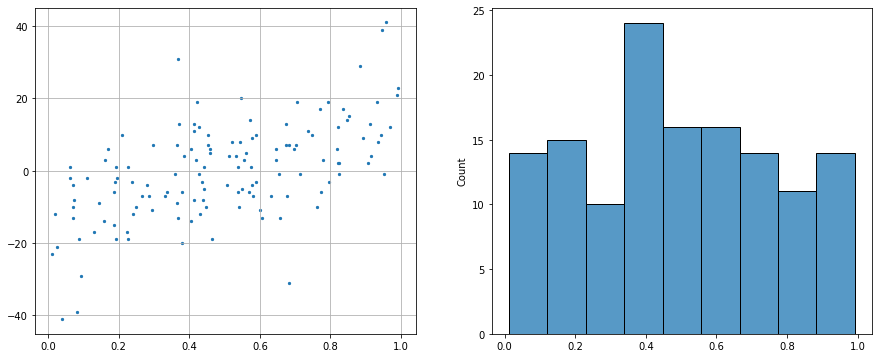

	 -> Scored 0.573

Validating on season 2016


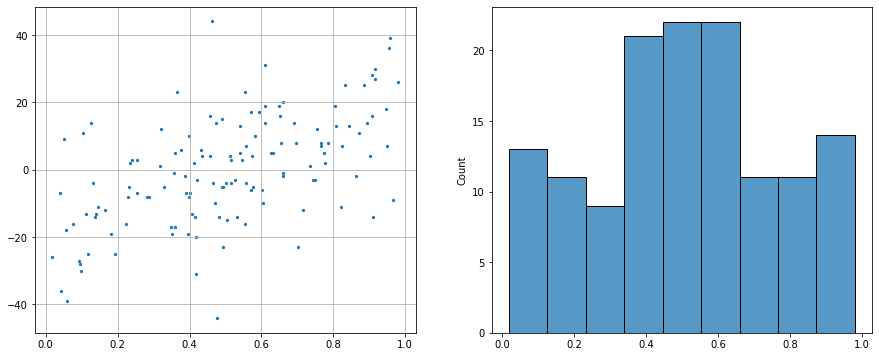

	 -> Scored 0.603

Validating on season 2017


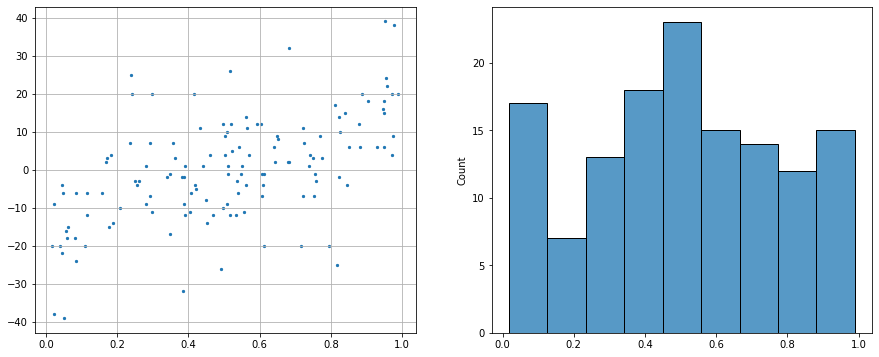

	 -> Scored 0.551

Validating on season 2018


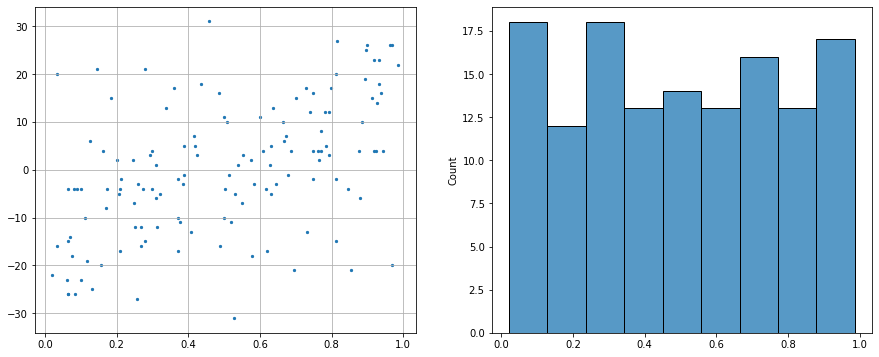

	 -> Scored 0.588

Validating on season 2019


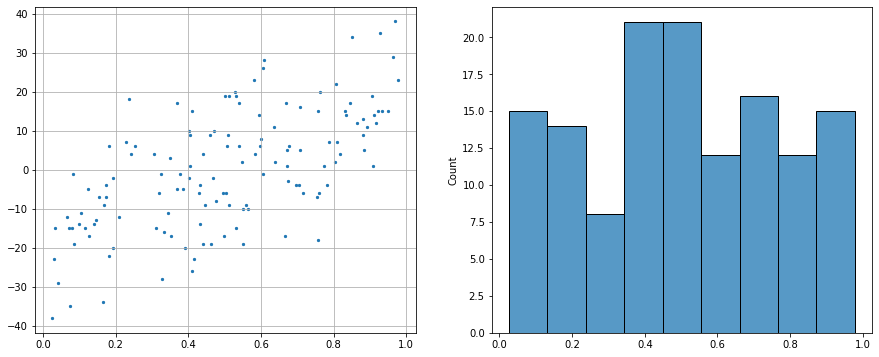

	 -> Scored 0.500

Validating on season 2021


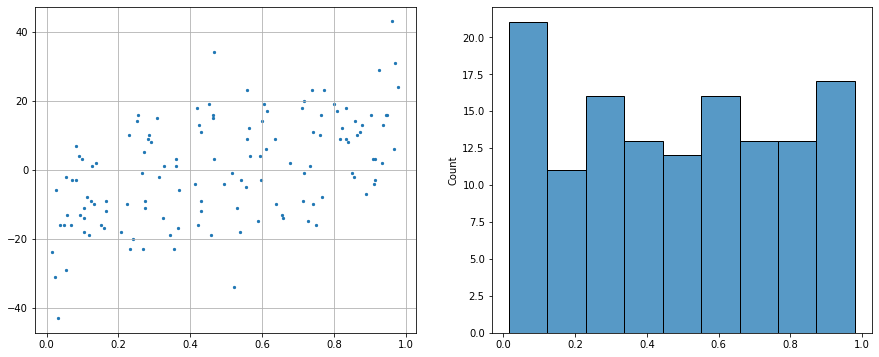

	 -> Scored 0.614

 Local CV is 0.572


In [175]:
pred_tests = kfold_reg(df, df_test[features], plot=True, verbose=1, mode="cls")

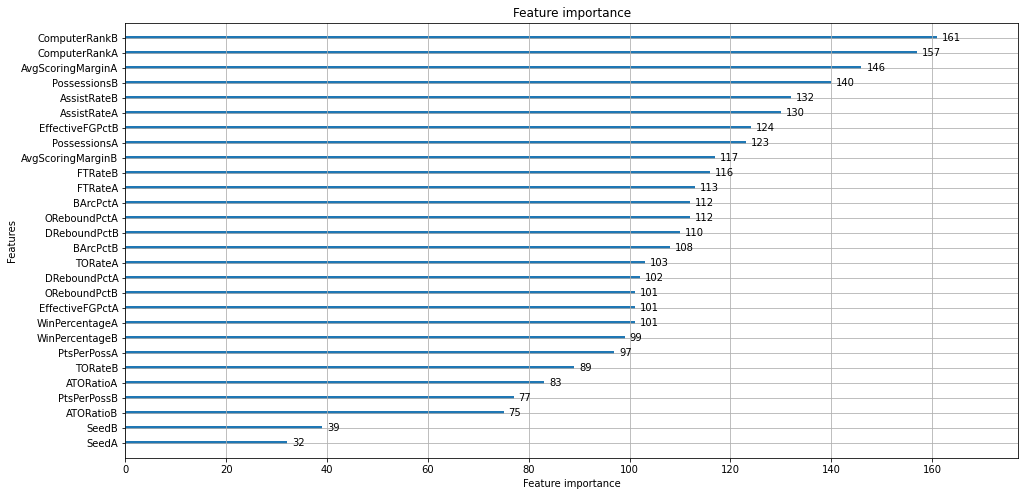

In [176]:
import lightgbm
f, ax = plt.subplots(figsize=(16, 8))
model = LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=random_state)
model.fit(X_train, y_train)
lightgbm.plot_importance(model, ax=ax)
plt.show()

In [177]:
pred_tests

[array([0.723025  , 0.9723937 , 0.7159856 , ..., 0.566022  , 0.4110674 ,
        0.30998814], dtype=float32),
 array([0.6830976 , 0.9562635 , 0.77736366, ..., 0.49340212, 0.32766977,
        0.3429961 ], dtype=float32),
 array([0.5800932 , 0.95464915, 0.75556666, ..., 0.7106156 , 0.34155944,
        0.34374318], dtype=float32),
 array([0.6411276 , 0.9436818 , 0.74240726, ..., 0.66886556, 0.41748202,
        0.29618376], dtype=float32),
 array([0.62050647, 0.9507133 , 0.69323814, ..., 0.67431754, 0.4993279 ,
        0.26506427], dtype=float32),
 array([0.6089455 , 0.9303209 , 0.6796612 , ..., 0.64202374, 0.4398279 ,
        0.33477846], dtype=float32)]

### 6B.) Preparing for Automatic Submission

In [178]:
pred_test = np.mean(pred_tests, 0)
sub = df_test[['ID', 'Pred']].copy()
sub['Pred'] = pred_test
# sub.to_csv('submission.csv', index=False)
sub.to_csv(submissions_path + '/March_ML_Mania_2022_Men_LGBM_Jimenez_v2.csv', index = False)

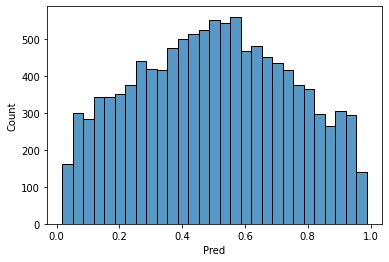

In [179]:
_ = sns.histplot(sub['Pred'])